### Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
import gc
from pathlib import Path


from math import radians, cos, sin, asin, sqrt
from urllib.request import urlopen
from imageio import imread


In [47]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor

useful kernels/ resources:
- https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
- https://towardsdatascience.com/another-machine-learning-walk-through-and-a-challenge-8fae1e187a64
- [nyc gov's page about taxis](https://www1.nyc.gov/site/tlc/index.page)

In [3]:
DATA_DIR = Path("data")

### Data explore and cleaning

#### Read in only subset of data for exploration/initial training since whole dataset is quite big

In [4]:
%%time

dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z")

df = pd.read_csv(DATA_DIR / "train.csv.zip", nrows=5_000_000,
                 parse_dates=['pickup_datetime'], date_parser=dateparser)

CPU times: user 1min 32s, sys: 2.71 s, total: 1min 34s
Wall time: 1min 37s


In [31]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


#### Get some basic stats about the training data
- target is `fare_amount`
- 4 location features (pickup lat/lng and dropoff lat/lng
- already can see some outliers/mistakes e.g. passenger_count = 0/ -1 USD fares etc

In [6]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


#### Also load in the test data so we can see what are reasonable ranges we need to worry about

In [7]:
df_test = pd.read_csv(DATA_DIR / "test.csv" ,parse_dates=['pickup_datetime'], date_parser=dateparser)
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [32]:
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


### Data cleaning

Check for NaNs

In [10]:
df.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64

In [8]:
# remove the rows with missing features since there aren't that many of them
df_cleaned = df.dropna()
df_cleaned.shape

(4999964, 8)

In [9]:
# remove unreasonable ranges:
# cannot have fares <$2.5 https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page, 
# cannot have 0 passenger counts 
# or passenger counts > 6 (https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page)
df_cleaned = df_cleaned.loc[df_cleaned["passenger_count"].between(1, 6)]
df_cleaned = df_cleaned.loc[df_cleaned["fare_amount"].ge(2.5)]

### Geo features

the min/max lat/lng values in the train set are a bit unrealistic-- whereas those in the test set are all "normal". Filter the train  set to only those lat/lngs

In [10]:
lat_min = np.min([df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()])
lat_max = np.max([df_test.pickup_latitude.max(), df_test.dropoff_latitude.max()])
lng_min = np.min([df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()])
lng_max = np.max([df_test.pickup_longitude.max(), df_test.dropoff_longitude.max()])

In [11]:
# sensible lat/lng bounding box values from the test set
bounding_box = (lat_min, lat_max, lng_min, lng_max)
print(bounding_box)

(40.568973, 41.709555, -74.263242, -72.986532)


In [12]:

# lat/lng use min max from test set
df_cleaned = df_cleaned.loc[df_cleaned["dropoff_latitude"].between(lat_min, lat_max)]
df_cleaned = df_cleaned.loc[df_cleaned["dropoff_longitude"].between(lng_min, lng_max)]
df_cleaned = df_cleaned.loc[df_cleaned["pickup_latitude"].between(lat_min, lat_max)]
df_cleaned = df_cleaned.loc[df_cleaned["pickup_longitude"].between(lng_min, lng_max)]


In [33]:
df_cleaned.shape

(4875269, 16)

In [35]:
MAP_URL = "https://www.openstreetmap.org/export#map=8/41.007/-73.500"
img_filename = f"nyc_{int(lat_min)}_{int(lat_max)}_{int(lng_min)}_{int(lng_max)}.png"

In [47]:
# nyc_map = imread(img_filename)
# fig, axs = plt.subplots(1, 2, figsize=(10,10))
# sample = df.sample(n=100000)
# axs[0].scatter(sample.pickup_longitude, sample.pickup_latitude, zorder=1, alpha=0.2, c='r', s=2)
# axs[0].set_xlim((bounding_box[0], bounding_box[1]))
# axs[0].set_ylim((bounding_box[2], bounding_box[3]))
# axs[0].set_title('Pickup locations')
# axs[0].imshow(nyc_map, zorder=0, extent=bounding_box)

In [50]:
def plot_on_map(df, BB, nyc_map, s=2, alpha=0.2):
#     with urlopen(nyc_map_url) as file:
#     nyc_map = imread(nyc_img_filename)
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    

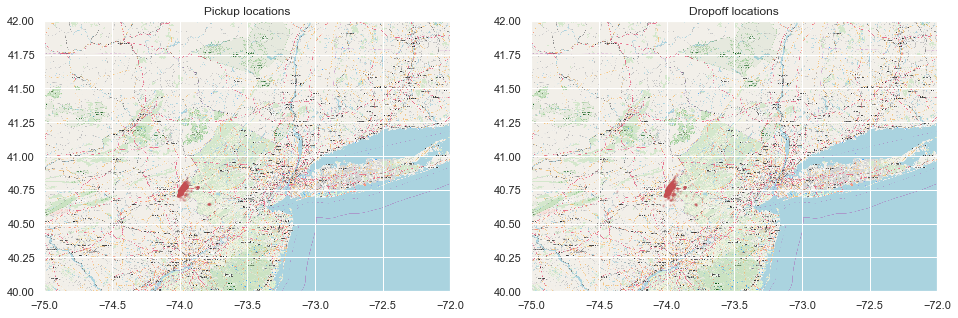

In [51]:
BB = (-75, -72, 40, 42)
plot_on_map(df_cleaned.sample(n=1000), BB, nyc_map, s=2, alpha=0.2)

Another feature is pickup/dropoff density by lat/lng at different times of day, e.g. dropoffs are gathered round the business centres in the morning on weekdays

In [13]:
def haversine(lng1, lng2, lat1, lat2):
    EARTH_RADIUS_KM = 6371.0088
    
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))

    # calculate haversine
    delta_lng = lng2 - lng1
    delta_lat = lat2 - lat1
   
    d = np.sin(delta_lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lng * 0.5) ** 2

    return 2 * EARTH_RADIUS_KM * np.arcsin(np.sqrt(d))

def haversine_manhattan(lng1, lng2, lat1, lat2):
    return haversine(lng1, lng2, 0, 0) + haversine(0, 0, lat1, lat2)

In [14]:
nbins = 150
pickup_density = np.zeros((nbins, nbins))
dropoff_density = np.zeros((nbins, nbins))

bin_width_lat = (lat_max - lat_min) / nbins
bin_width_lng = (lng_max - lng_min) / nbins

bin_width_lat_km = haversine(lng_min, lng_min, lat_min, lat_max)
bin_width_lng_km = haversine(lng_min, lng_max, lat_min, lat_min)


In [15]:
%%time
bins_lat = np.arange(lat_min, lat_max + bin_width_lat, bin_width_lat)
bins_lng = np.arange(lng_min, lng_max + bin_width_lng, bin_width_lng )

idx_pickup_lat = np.digitize(df_cleaned.pickup_latitude, bins_lat)
idx_dropoff_lat = np.digitize(df_cleaned.dropoff_latitude, bins_lat)

idx_pickup_lng = np.digitize(df_cleaned.pickup_longitude, bins_lng)
idx_dropoff_lng = np.digitize(df_cleaned.pickup_longitude, bins_lng)

dxdy = bin_width_lat_km * bin_width_lng_km
        


CPU times: user 616 ms, sys: 5.14 ms, total: 621 ms
Wall time: 629 ms


In [15]:
lat_max

41.709555

In [16]:
%%time

# for lng in range(nbins):
#     for lat in range(nbins):
#         pickup_density [lng, lat] = np.sum((idx_pickup_lat == nbins - lat) & (idx_pickup_lng == lng + 1))
#         dropoff_density [lng, lat] = np.sum((idx_dropoff_lat == nbins - lat) & (idx_dropoff_lng == lng + 1))
        
# pickup_density = pickup_density/ dxdy


# np.map

hist_pickup = np.histogram2d(df_cleaned.pickup_longitude, df_cleaned.pickup_latitude,density=True,
                                 bins=[bins_lng, bins_lat])

hist_dropoff = np.histogram2d(df_cleaned.dropoff_longitude, df_cleaned.dropoff_latitude,density=True,
                                 bins=[bins_lng, bins_lat])

CPU times: user 5.1 s, sys: 891 ms, total: 5.99 s
Wall time: 6.15 s


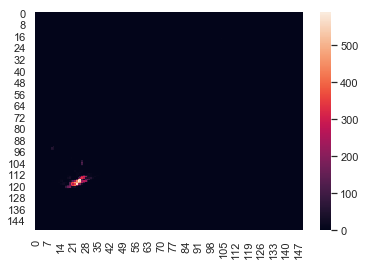

In [79]:
sns.heatmap(np.flip(hist_pickup[0], 0))

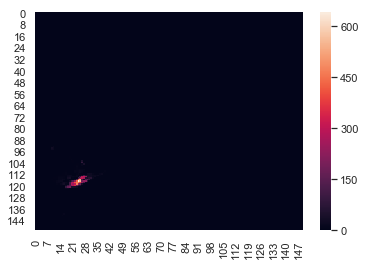

In [80]:
sns.heatmap(np.flip(hist_dropoff[0], 0))

### Distance features
- expect longer trips to have a higher price
- since the streets are on a grid, also caculate the haversine manhattan distance to see if it is better than the straight line haversine

In [34]:
df_cleaned = df_cleaned.assign(travel_dist_manhattan=haversine_manhattan(df_cleaned.pickup_longitude, 
                                                df_cleaned.dropoff_longitude,
                                                df_cleaned.pickup_latitude,
                                                df_cleaned.dropoff_latitude),
                              travel_dist=haversine(df_cleaned.pickup_longitude, 
                                                df_cleaned.dropoff_longitude,
                                                df_cleaned.pickup_latitude,
                                                df_cleaned.dropoff_latitude))

Text(0.5, 1.0, 'haversine')

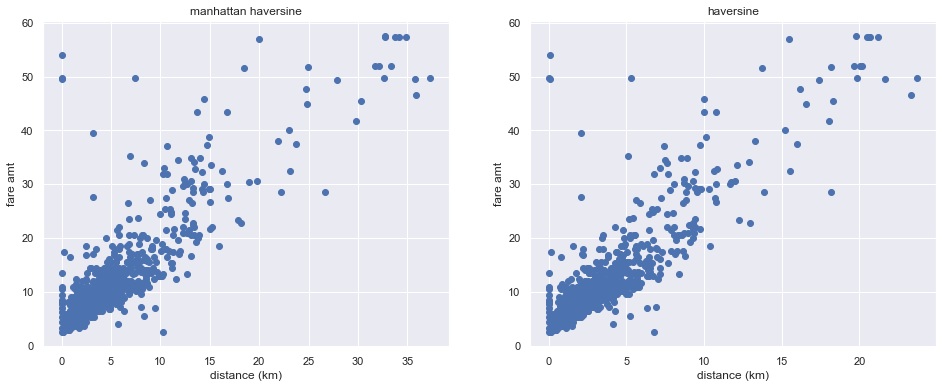

In [35]:
plt_data = df_cleaned.sample(n=1000)
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(plt_data.travel_dist_manhattan, plt_data.fare_amount)
axs[0].set_xlabel("distance (km)")
axs[0].set_ylabel("fare amt")
axs[0].set_title('manhattan haversine')

axs[1].scatter(plt_data.travel_dist, plt_data.fare_amount)
axs[1].set_xlabel("distance (km)")
axs[1].set_ylabel("fare amt")
axs[1].set_title('haversine')

We can see that there's a linear relation between distance travelled and fare (with an offset-- this will correspond to the starting meter price of $2.5). But also that there's some zero (?) distance rides with vrey high fares-- these are likely to be mistakes

In [36]:
df_cleaned = df_cleaned.loc[df_cleaned["travel_dist"].ge(0)]
df_cleaned.shape

(4875269, 16)

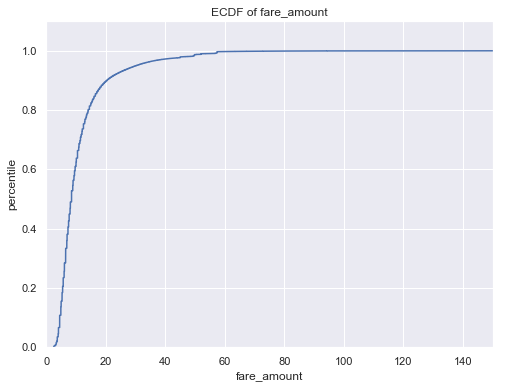

In [18]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

def plot_ecdf(arr, xlim):
    x, y = ecdf(arr)
    plt.figure(figsize=(8,6))
    plt.plot(x, y)
    plt.ylim([0, 1.1])
    plt.xlim([0, xlim])
    plt.title("ECDF of fare_amount")
    plt.ylabel("percentile")
    plt.xlabel("fare_amount")
    
plot_ecdf(df_cleaned.fare_amount.to_numpy(), 150)

90\% of the fares are < $20, and almost 100\% by $40, so can bin on regular intervals <= 40 and one for >40

In [41]:
df_cleaned["fare_bin"] = pd.cut(df_cleaned.fare_amount, bins = np.arange(0, 50, 5)).astype("category")

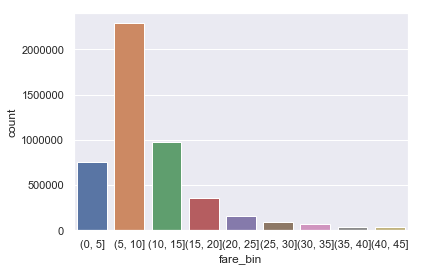

In [42]:

sns.countplot(x = "fare_bin",data=df_cleaned)


Time features

In [37]:

df_cleaned["year"] = df_cleaned["pickup_datetime"].dt.year
df_cleaned["month"] = df_cleaned["pickup_datetime"].dt.month
df_cleaned["day"] = df_cleaned["pickup_datetime"].dt.day

df_cleaned["hour"] = df_cleaned["pickup_datetime"].dt.hour

In [38]:
df_cleaned["day_of_week"] =  df_cleaned["pickup_datetime"].dt.weekday

In [39]:
df_cleaned["hour"].min()

0

In [40]:
day_of_week_filter = df_cleaned.day_of_week.between(1,5)
hour_filter = df_cleaned.hour.between(16,20)

df_cleaned["is_rushhour"] =  day_of_week_filter & hour_filter &  df_cleaned.hour.between(16,20)
df_cleaned["is_weekday"]=  day_of_week_filter

In [ ]:
df_cleaned.drop("key", inplace=True, axis=1)

### Modelling baseline

#### Simple Linear regression

Using only the travel distance:

In [55]:
target = df_cleaned.fare_amount
X = df_cleaned[["travel_dist_manhattan"]]
clf = LinearRegression()
scores = cross_val_score(clf, X, target, cv=5, scoring="neg_mean_squared_error")
print("RMSE: %0.2f" % (np.sqrt(-scores.mean())))

RMSE: 5.65


In [57]:

X = df_cleaned[["travel_dist"]]
clf = LinearRegression()
scores = cross_val_score(clf, X, target, cv=5, scoring="neg_mean_squared_error")
print("RMSE: %0.2f" % (np.sqrt(-scores.mean())))

RMSE: 5.52


In [74]:
# travel_dist is slightly better so use that for baseline
X = df_cleaned[["travel_dist"]]
clf = LinearRegression()
clf.fit(X, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

This is similar to the linear model baselines on kaggle (https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/leaderboard) -- obviously this is only on our training subset. Let's see how it does on the test set

In [62]:
df_test = df_test.assign(travel_dist_manhattan=haversine_manhattan(df_test.pickup_longitude, 
                                                df_test.dropoff_longitude,
                                                df_test.pickup_latitude,
                                                df_test.dropoff_latitude),
                              travel_dist=haversine(df_test.pickup_longitude, 
                                                df_test.dropoff_longitude,
                                                df_test.pickup_latitude,
                                                df_test.dropoff_latitude))

In [75]:
df_predict = df_test[["key", "travel_dist"]]
df_predict["fare_amount"] = clf.predict(df_predict.travel_dist.to_numpy().reshape(-1, 1))


/Users/wwymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
df_predict.drop("travel_dist", axis=1, inplace=True)

/Users/wwymak/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [78]:
df_predict.to_csv("submission_simple_lr_on_dist.csv", index=None)

In [79]:
!kaggle competitions submit -f submission_simple_lr_on_dist.csv -m "simple linear reg on travel dist" new-york-city-taxi-fare-prediction

100%|████████████████████████████████████████| 454k/454k [00:07<00:00, 62.2kB/s]
Successfully submitted to New York City Taxi Fare Prediction

which turns out to score 5.6 RMSE on the test set (which is a teeny bit better than the competition baseline at 5,74)

Now let's train on all the features

In [43]:
X = df_cleaned[['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'travel_dist_manhattan', 'travel_dist',
       'year', 'month', 'day', 'hour', 'day_of_week', 'is_rushhour',
       'is_weekday']]
target = df_cleaned.fare_amount
clf = LinearRegression()
scores = cross_val_score(clf, X, target, cv=5, scoring="neg_mean_squared_error")
print("RMSE: %0.2f" % (np.sqrt(-scores.mean())))

RMSE: 5.34


### random forest

In [ ]:
xgb_model = xgb.XGBRegressor(n_jobs=3)
# clf = GridSearchCV(xgb_model,
#                    {'max_depth': [2,4,6],
#                     'n_estimators': [50,100,200]}, verbose=1)

# clf.fit(X,target)
# print(clf.best_score_)
# print(clf.best_params_)

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.1, random_state=0)
xgb_model.fit(X_train, y_train)

/Users/wwymak/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
